Creates frame rate statistics from a H.264 video stream.
The last line of code can be used to export the graph to a PNG.

## How to get the graph

Create a tcp dump of the video stream. Convert the recorded stream by using [decodeH264Stream.sh](https://github.com/tederer/octowatch-evaluation/blob/main/measurements/framerate/decodeH264Stream.sh). The output of that script should look something like ...

```
timeInSecondsSinceEpoch;source;destination;databytes
1710411296.845277;192.168.0.105.8888;192.168.0.183.64016;000000012764
1710411296.845301;192.168.0.105.8888;192.168.0.183.64016;019eac8b31d4
1710411296.845351;192.168.0.105.8888;192.168.0.183.64016;32d0c168303e
1710411296.845364;192.168.0.105.8888;192.168.0.183.64016;52a3f5e18e2f
1710411296.877550;192.168.0.105.8888;192.168.0.183.64016;00000001219a
```

The "databytes" column contains the content of the first 6 bytes, which are necessary for deciding what (I-Frame, P-Frame, ...) it is.

Store that content in a file and upload it. Correct the
filename in "inputFile" if necessary.

## H.264 Frame type identification

According the the specification ("B.2 Byte stream NAL unit decoding process"), each NAL begins with 0x00000001.

## References:

* [H.264 specification](https://www.itu.int/rec/dologin_pub.asp?lang=e&id=T-REC-H.264-202108-I!!PDF-E&type=items)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
#inputFile           = 'h264_with_activity.csv'
inputFile           = 'h264_without_activity.csv'
durationFigureTitle = 'without activity'

response = requests.get('https://raw.githubusercontent.com/tederer/octowatch-evaluation/main/measurements/framerate/' + inputFile)
with open(inputFile, 'wb') as fd:
    for chunk in response.iter_content(chunk_size=128):
        fd.write(chunk)

NALs found: 2097


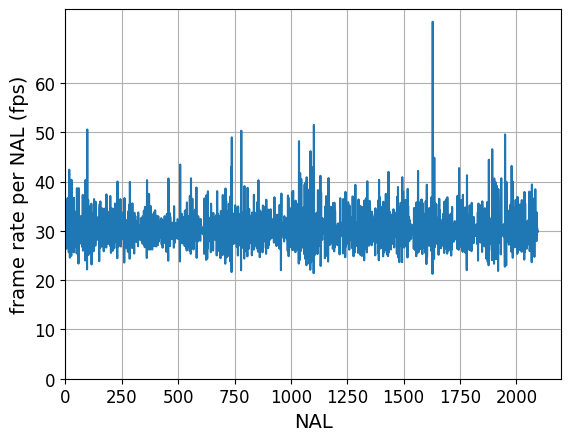

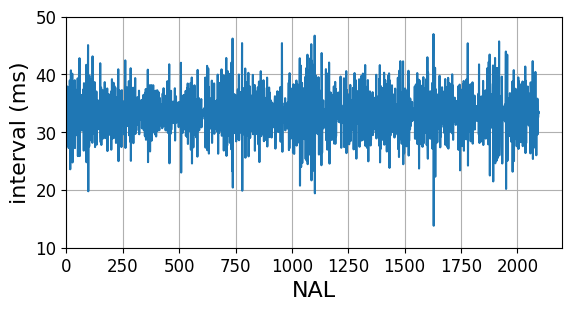

In [3]:
csvFile = pd.read_csv(inputFile, sep=';')

type(csvFile.iloc[0])
csvFile.iloc[0]

nals = []

for index in range(1, csvFile.shape[0]):
  row = csvFile.iloc[index]
  timeInSecondsSinceEpoch = row['timeInSecondsSinceEpoch']
  databytes               = row['databytes']
  if databytes.startswith('00000001'): # contains start of NAL
    nals.append(row)

print('NALs found:', len(nals))

plt.rcParams.update({'font.size': 12})

previousTimestampInSec = nals[0]['timeInSecondsSinceEpoch']
fps                    = np.zeros(len(nals) - 1);
durationInMs           = np.zeros(len(nals) - 1);

for index in range(1, len(nals)):
  currentTimestampInSec   = nals[index]['timeInSecondsSinceEpoch']
  durationInSec           = currentTimestampInSec - previousTimestampInSec
  framesPerSecond         = 1 / durationInSec
  previousTimestampInSec  = currentTimestampInSec
  fps[index - 1]          = framesPerSecond
  durationInMs[index - 1] = durationInSec * 1000

fpsFigure, fpsPerFrameAxis = plt.subplots()
fpsPerFrameAxis.plot(fps)
fpsPerFrameAxis.set_xlabel('NAL', fontsize=14)
fpsPerFrameAxis.set_ylabel('frame rate per NAL (fps)', fontsize=14)
fpsPerFrameAxis.set_xlim(0)
fpsPerFrameAxis.set_ylim(0)
fpsPerFrameAxis.grid(True)
fpsPerFrameAxis.set_yticks([0,10,20,30,40,50,60])
#fpsPerFrameAxis.set_title(durationFigureTitle)

durationFigure, durationAxis = plt.subplots(figsize=(6.4, 3))
durationAxis.plot(durationInMs)
durationAxis.set_xlabel('NAL', fontsize=16)
durationAxis.set_ylabel('interval (ms)', fontsize=16)
durationAxis.set_xlim(0)
durationAxis.set_yticks([10,20,30,40,50])
#durationAxis.set_ylim(bottom = 10, top = 50)
durationAxis.grid(True)
#durationAxis.set_title(durationFigureTitle)

fpsFigure.savefig('fpsFigure.png', bbox_inches='tight', pad_inches=0.05, dpi=300)
durationFigure.savefig('durationFigure.png', bbox_inches='tight', pad_inches=0.05, dpi=300)

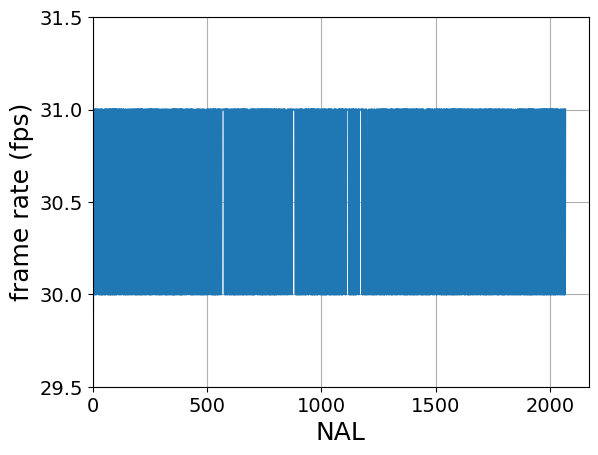

In [4]:
# Using a sliding window to count for each NAL how many NALs are not older
# than 1 second.

oldestTimestamp  = nals[0]['timeInSecondsSinceEpoch']
startIndex       = 0
currentIndex     = startIndex + 1
slidingWindowFps = []

plt.rcParams.update({'font.size': 14})

while currentIndex < len(nals):
  timeDiff = nals[currentIndex]['timeInSecondsSinceEpoch'] - oldestTimestamp
  if timeDiff > 1.0:
    slidingWindowFps.append((currentIndex - startIndex) - 1)
    break
  currentIndex += 1

while currentIndex < len(nals):
  currentNewestTimestamp = nals[currentIndex]['timeInSecondsSinceEpoch']
  index                  = currentIndex - 1

  while index >= 0:
    timeDiff = currentNewestTimestamp - nals[index]['timeInSecondsSinceEpoch']
    if timeDiff > 1.0:
      slidingWindowFps.append(currentIndex - index)
      break
    index -= 1

  currentIndex += 1

slidingFigure, slidingWindowAxis = plt.subplots()
slidingWindowAxis.plot(slidingWindowFps)
slidingWindowAxis.set_xlabel('NAL', fontsize=18)
slidingWindowAxis.set_ylabel('frame rate (fps)', fontsize=18)
slidingWindowAxis.set_xlim(0)
slidingWindowAxis.set_ylim(bottom = 29.5, top = 31.5)
slidingWindowAxis.grid(True)
#slidingWindowAxis.set_title(durationFigureTitle)

slidingWindowAxis.yaxis.set_ticks(np.arange(29.5, 31.6, 0.5))

slidingFigure.savefig('slidingFigure.png', bbox_inches='tight', dpi=300)